In [1]:
import sys
import os
import torch
import cv2 as cv
import numpy as np
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

In [2]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.7.6 (tags/v3.7.6:43364a7ae0, Dec 19 2019, 00:42:30) [MSC v.1916 64 bit (AMD64)]
10.1
1
True


In [3]:
lookup = dict()
reverselookup = dict()

count = 0

for j in sorted(os.listdir('./dynamicdata/')):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count += 1
        
print(lookup)
print(reverselookup)

{'close': 0, 'fingerright': 1, 'fistround': 2, 'palmdown': 3, 'palmleft': 4, 'scrollup': 5}
{0: 'close', 1: 'fingerright', 2: 'fistround', 3: 'palmdown', 4: 'palmleft', 5: 'scrollup'}


In [4]:
num_classes = len(reverselookup)
video_num = 100
frame_count = 16

path = './dynamicdata/'

image_size = 112

transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomResizedCrop(size=image_size, scale=(0.95, 1.0)),
                transforms.ColorJitter(),
                transforms.ToTensor(), 
                transforms.Normalize([0.5], [0.5])
                ])
videoset = []
videoclass = []

for i in range(num_classes):
  for k in range(video_num):
    gest = None
    for j in range(frame_count):
      #print(path+str(reverselookup[i])+'/'+str(k+1)+'/'+str(j+1)+'.jpg')
      img = Image.open(path+str(reverselookup[i])+'/'+str(k+1)+'/'+str(j+1)+'.jpg')
      #print(img.shape)
      img = transform(img)
      img = img.view(-1, image_size, image_size, 1)
      
      if gest is None:
        gest = img
      else:
        gest = torch.cat((gest, img), dim=3)
    print('.', end=' ')
    videoset.append(gest)
  videoclass.append(videoset)
  print(len(videoset))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 100
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 200
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 300
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 400
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [5]:
class GestureDataset(Dataset):
    """Dynamic Gesture dataset."""

    def __init__(self, tensor_list, num_classes=6, num_videos=100):

        self.tensor_list = tensor_list
        self.num_classes = num_classes
        self.num_videos = num_videos
        #self.transform = transform

    def __len__(self):
        return len(self.tensor_list)

    def __getitem__(self, idx):
        vid = self.tensor_list[idx]
        label = int(idx/self.num_videos)

        return (vid, label)

dataset = GestureDataset(videoset)
print(dataset)

In [6]:
random_seed = random.randint(1, 100)
batch = 16

dataset_size = len(dataset)
split = int(0.05*dataset_size)
print('Size of dataset is: ', dataset_size)
print('Split value: ', split)
indices = list(range(dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=train_sampler,
                                            num_workers = 0)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, sampler=valid_sampler,
                                            num_workers = 0)

print(len(train_loader))
print(len(valid_loader))

Size of dataset is:  600
Split value:  30
36
2


In [7]:
torch.save(train_loader, './dl_train_dynamicGest2.pth')
torch.save(valid_loader, './dl_valid_dynamicGest2.pth')

In [8]:
# Iterate through the dataloader once
trainiter = iter(train_loader)
features, labels = next(trainiter)
#features.shape, labels.shape
print(features.shape)

torch.Size([16, 1, 112, 112, 16])


In [9]:
#def weights_init(m):
    #isinstance(m, nn.Conv3d):
        #torch.nn.init.xavier_uniform_

In [10]:
class C3D(nn.Module):
  """
  The C3D network as described in [1]
  Batch Normalization as described in [2]

  """

  def __init__(self):
    super(C3D, self).__init__()

    self.conv1 = nn.Conv3d(1, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv1_bn = nn.BatchNorm3d(64)
    self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

    self.conv2 = nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv2_bn = nn.BatchNorm3d(128)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3a = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv3a_bn = nn.BatchNorm3d(256)
    self.conv3b = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv3b_bn = nn.BatchNorm3d(256)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv4a = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv4a_bn = nn.BatchNorm3d(512)
    self.conv4b = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv4b_bn = nn.BatchNorm3d(512)
    self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv5a = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv5a_bn = nn.BatchNorm3d(512)
    self.conv5b = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
    #self.conv5b_bn = nn.BatchNorm3d(512)
    self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

    self.fc6 = nn.Linear(2048, 1024)
    #self.fc7 = nn.Linear(1024, 1024)
    self.fc8 = nn.Linear(1024, num_classes)
    self.relu = nn.ReLU()
    self.logsoftmax = nn.Softmax(dim=1)

  def forward(self, x):

    h = x.view(-1, 1, 16, 112, 112)

    h = self.relu(self.conv1(h))
    h = self.pool1(h)

    h = self.relu(self.conv2(h))
    h = self.pool2(h)

    h = self.relu(self.conv3a(h))
    h = self.relu(self.conv3b(h))
    h = self.pool3(h)

    h = self.relu(self.conv4a(h))
    h = self.relu(self.conv4b(h))
    h = self.pool4(h)

    h = self.relu(self.conv5a(h))
    h = self.relu(self.conv5b(h))
    h = self.pool5(h)

    h = h.view(-1, 2048)
    h = self.relu(self.fc6(h))
    #h = self.relu(self.fc7(h))
    h = self.fc8(h)
    h = self.logsoftmax(h)
    return h

"""
References
----------
[1] Tran, Du, et al. "Learning spatiotemporal features with 3d convolutional networks." 
Proceedings of the IEEE international conference on computer vision. 2015.
[2] Ioffe, Surgey, et al. "Batch Normalization: Accelerating deep network training 
by reducing internal covariate shift."
arXiv:1502.03167v2 [cs.LG] 13 Feb 2015
"""

'\nReferences\n----------\n[1] Tran, Du, et al. "Learning spatiotemporal features with 3d convolutional networks." \nProceedings of the IEEE international conference on computer vision. 2015.\n[2] Ioffe, Surgey, et al. "Batch Normalization: Accelerating deep network training \nby reducing internal covariate shift."\narXiv:1502.03167v2 [cs.LG] 13 Feb 2015\n'

In [11]:
#torch.save(model, 'drive/My Drive/Colab Notebooks/ITSP/c3d.pth')
model = C3D()
print(model)

C3D(
  (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1

In [12]:
total_params = sum(p.numel() for p in model.parameters())

print(f'{total_params:,} total parameters')

total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'{total_trainable:,} trainable parameters.')

4,650,566 total parameters
4,650,566 trainable parameters.


In [18]:
# Move to gpu
model = model.to('cuda')
# Distribute across 2 gpus
model = nn.DataParallel(model)

loss_func = F.cross_entropy
optimizer = optim.Adam(model.parameters(), betas=(0.5, 0.99), lr = 0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [19]:
def accuracy(out, yb):
    #print(yb, out)
    pred = torch.argmax(out, keepdim= False, dim=1)
    print(yb, pred)
    return (pred == yb).float().mean() 

In [20]:
def fit(model, epochs, train_loader, valid_loader, opt):
    losses = []
    
    for epoch in range(epochs):
        train_loss =0
        train_acc =0
        model.train()
        for xb, yb in train_loader:
            xb =xb.to(device)
            yb = yb.to(device)
            pred = model(xb.float())
            pred.to(device)
            loss = loss_func(pred, yb)
            #back propogation
            loss.backward()
            opt.step()
            opt.zero_grad()      
            train_acc += accuracy(pred, yb)
            train_loss += loss
            

        losses.append(train_loss)
        print("Iteration no: "+ str(epoch), "loss = "+str(losses[epoch].item()))
        print("Accuracy of train set:", train_acc/len(train_loader))
        lr_scheduler.step(train_loss/len(train_loader))
        
        
        model.eval()    
        with torch.no_grad():
            valid_acc=0
            loss_valid = 0
            for xb_valid, yb_valid in valid_loader:
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)
                pred_valid = model(xb_valid.float())
                pred_valid.to(device)
                valid_acc += accuracy(pred_valid, yb_valid)
                loss_valid += loss_func(pred_valid, yb_valid)
            print("Accuracy of validation set :", valid_acc/len(valid_loader))
            #callbacks = [EarlyStopping(monitor='valid_acc', verbose=False, mode='max', patience=10)]

    plt.plot(losses)
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.show()

In [21]:
#model.set_callbacks(callbacks)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, eps = 10e-15)

tensor([4, 2, 1, 0, 0, 3, 3, 0, 1, 4, 2, 3, 0, 2, 4, 0], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([2, 0, 2, 4, 3, 0, 3, 0, 1, 2, 4, 5, 3, 4, 2, 5], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([5, 0, 3, 5, 0, 4, 4, 4, 5, 0, 5, 3, 3, 5, 4, 1], device='cuda:0') tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 2, 2, 5, 0, 1, 3, 1, 5, 2, 0, 1, 0, 1, 4], device='cuda:0') tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([0, 4, 3, 1, 5, 0, 5, 0, 1, 0, 3, 3, 5, 0, 2, 0], device='cuda:0') tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 0, 4, 4, 2, 4, 5, 0, 2, 1, 1, 2, 4, 2, 5], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 5, 4, 3, 0, 2, 4, 3, 1, 5, 4, 5, 1, 3, 5], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

tensor([3, 5, 1, 0, 1, 4, 4, 1, 2, 0, 3, 5, 1, 2, 5, 3], device='cuda:0') tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([1, 5, 1, 2, 1, 5, 3, 1, 1, 4, 4, 1, 3, 4, 3, 3], device='cuda:0') tensor([1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2], device='cuda:0')
tensor([2, 3, 3, 1, 5, 4, 1, 4, 2, 1, 1, 3, 2, 0, 1, 5], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([2, 5, 2, 2, 0, 4, 0, 4, 4, 5, 4, 1, 3, 4, 2, 2], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([3, 1, 5, 0, 5, 1, 1, 0, 4, 4, 4, 5, 5, 1, 5, 2], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([3, 0, 0, 2, 2, 0, 3, 1, 4, 0, 1, 4, 3, 1, 1, 0], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([5, 0, 0, 0, 0, 3, 5, 3, 0, 3, 0, 0, 3, 4, 5, 1], device='cuda:0') tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

tensor([4, 3, 3, 4, 5, 5, 4, 2, 4, 2, 5, 1, 2, 2, 3, 1], device='cuda:0') tensor([4, 0, 0, 4, 4, 0, 4, 4, 4, 4, 5, 4, 4, 4, 0, 4], device='cuda:0')
tensor([2, 0, 1, 4, 2, 3, 0, 4, 5, 4], device='cuda:0') tensor([4, 0, 4, 4, 4, 0, 0, 4, 3, 4], device='cuda:0')
Iteration no: 2 loss = 59.72825622558594
Accuracy of train set: tensor(0.3247, device='cuda:0')
tensor([2, 1, 5, 5, 4, 3, 1, 4, 2, 5, 3, 3, 3, 2, 4, 5], device='cuda:0') tensor([4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 3, 3, 4, 4, 3], device='cuda:0')
tensor([5, 5, 0, 1, 3, 0, 0, 4, 2, 5, 5, 2, 5, 2], device='cuda:0') tensor([4, 4, 0, 4, 0, 3, 3, 4, 4, 3, 4, 4, 4, 4], device='cuda:0')
Accuracy of validation set : tensor(0.2589, device='cuda:0')
tensor([4, 0, 2, 3, 5, 5, 0, 3, 1, 5, 5, 3, 1, 0, 2, 2], device='cuda:0') tensor([4, 0, 4, 3, 4, 4, 3, 0, 4, 4, 4, 3, 4, 3, 4, 4], device='cuda:0')
tensor([4, 5, 1, 4, 1, 0, 1, 5, 4, 2, 4, 5, 4, 2, 2, 1], device='cuda:0') tensor([4, 0, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
ten

tensor([5, 5, 5, 2, 3, 0, 2, 2, 1, 5, 0, 5, 2, 5, 0, 1], device='cuda:0') tensor([5, 3, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 4], device='cuda:0')
tensor([3, 1, 2, 3, 0, 1, 3, 3, 0, 4, 1, 2, 1, 3, 5, 4], device='cuda:0') tensor([3, 5, 5, 3, 3, 5, 3, 3, 3, 4, 1, 5, 3, 3, 3, 4], device='cuda:0')
tensor([5, 0, 3, 2, 0, 4, 0, 2, 5, 4, 4, 2, 2, 3, 4, 2], device='cuda:0') tensor([5, 3, 3, 5, 3, 4, 5, 5, 5, 4, 4, 4, 5, 3, 4, 4], device='cuda:0')
tensor([4, 3, 0, 3, 2, 2, 3, 4, 0, 5, 4, 1, 3, 2, 5, 4], device='cuda:0') tensor([4, 3, 3, 3, 4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4], device='cuda:0')
tensor([4, 0, 1, 3, 1, 0, 2, 5, 4, 0, 4, 0, 2, 5, 5, 0], device='cuda:0') tensor([4, 3, 4, 3, 4, 3, 4, 5, 4, 3, 4, 3, 4, 5, 5, 4], device='cuda:0')
tensor([2, 1, 4, 3, 0, 1, 4, 3, 5, 1, 2, 3, 2, 2, 5, 4], device='cuda:0') tensor([4, 4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 4, 4, 5, 4], device='cuda:0')
tensor([5, 2, 1, 4, 4, 1, 4, 1, 2, 1, 0, 1, 5, 5, 5, 5], device='cuda:0') tensor([5, 4, 4, 4, 4, 4, 4, 5, 4, 5, 

tensor([2, 5, 4, 5, 3, 4, 1, 3, 0, 0, 0, 2, 5, 2, 5, 2], device='cuda:0') tensor([2, 5, 4, 5, 0, 4, 2, 0, 0, 0, 0, 2, 5, 2, 5, 2], device='cuda:0')
tensor([4, 5, 0, 1, 5, 5, 0, 2, 4, 4, 3, 4, 5, 4, 2, 2], device='cuda:0') tensor([4, 5, 0, 2, 5, 5, 0, 2, 4, 4, 0, 4, 5, 4, 2, 2], device='cuda:0')
tensor([2, 2, 3, 3, 5, 1, 1, 4, 3, 3, 2, 3, 4, 0, 1, 4], device='cuda:0') tensor([4, 4, 5, 5, 5, 2, 4, 4, 5, 0, 2, 0, 4, 0, 2, 4], device='cuda:0')
tensor([0, 0, 5, 1, 3, 0, 2, 3, 5, 2, 3, 1, 0, 0, 5, 5], device='cuda:0') tensor([0, 0, 5, 2, 0, 0, 2, 0, 5, 2, 0, 2, 0, 0, 5, 5], device='cuda:0')
tensor([4, 3, 3, 0, 1, 2, 3, 3, 5, 3, 0, 2, 5, 1, 3, 0], device='cuda:0') tensor([2, 0, 0, 5, 2, 2, 0, 0, 5, 0, 0, 2, 5, 2, 0, 0], device='cuda:0')
tensor([0, 2, 4, 2, 3, 3, 5, 4, 0, 5, 2, 0, 4, 3, 1, 0], device='cuda:0') tensor([5, 2, 4, 2, 0, 0, 5, 4, 0, 5, 2, 0, 4, 5, 2, 0], device='cuda:0')
tensor([1, 5, 4, 0, 1, 5, 5, 2, 0, 0], device='cuda:0') tensor([2, 5, 4, 0, 2, 5, 5, 2, 5, 0], device='cuda:0')


tensor([0, 0, 2, 1, 1, 0, 0, 1, 2, 4, 4, 5, 0, 3, 5, 4], device='cuda:0') tensor([3, 3, 2, 1, 1, 3, 3, 1, 2, 4, 4, 5, 3, 3, 5, 4], device='cuda:0')
tensor([1, 4, 3, 2, 0, 5, 4, 4, 0, 4, 2, 3, 1, 5, 3, 3], device='cuda:0') tensor([4, 4, 3, 2, 3, 5, 4, 4, 0, 4, 2, 3, 2, 5, 3, 3], device='cuda:0')
tensor([2, 2, 2, 5, 5, 1, 5, 1, 0, 2, 2, 3, 2, 3, 3, 4], device='cuda:0') tensor([2, 2, 2, 5, 5, 2, 5, 2, 3, 2, 2, 3, 2, 5, 3, 4], device='cuda:0')
tensor([4, 5, 4, 4, 5, 1, 5, 1, 5, 0, 4, 3, 3, 4, 1, 5], device='cuda:0') tensor([4, 5, 4, 4, 5, 2, 5, 2, 5, 3, 4, 3, 3, 4, 2, 5], device='cuda:0')
tensor([3, 1, 1, 4, 2, 3, 3, 0, 2, 2, 3, 4, 1, 2, 3, 1], device='cuda:0') tensor([3, 2, 5, 4, 2, 3, 3, 3, 2, 2, 3, 4, 2, 2, 3, 2], device='cuda:0')
tensor([1, 4, 0, 1, 4, 1, 3, 1, 5, 5, 2, 3, 4, 0, 1, 3], device='cuda:0') tensor([2, 4, 3, 2, 4, 2, 3, 2, 5, 5, 2, 3, 4, 3, 2, 3], device='cuda:0')
tensor([3, 4, 4, 4, 2, 3, 3, 0, 3, 0, 0, 3, 0, 2, 1, 4], device='cuda:0') tensor([3, 4, 4, 4, 1, 3, 3, 3, 3, 3, 

tensor([3, 1, 1, 1, 1, 4, 4, 5, 2, 4, 2, 1, 3, 1, 0, 3], device='cuda:0') tensor([3, 1, 1, 1, 1, 4, 4, 5, 1, 4, 2, 1, 3, 1, 3, 3], device='cuda:0')
tensor([2, 5, 5, 0, 0, 5, 3, 2, 4, 3, 4, 0, 3, 3, 5, 1], device='cuda:0') tensor([2, 5, 5, 3, 3, 5, 3, 2, 4, 3, 4, 3, 3, 3, 5, 1], device='cuda:0')
tensor([5, 5, 3, 5, 3, 4, 2, 4, 4, 5, 0, 2, 5, 3, 2, 2], device='cuda:0') tensor([5, 5, 3, 5, 3, 4, 2, 4, 4, 5, 3, 2, 5, 3, 2, 2], device='cuda:0')
tensor([3, 4, 0, 3, 0, 2, 1, 4, 5, 4, 1, 2, 4, 0, 5, 1], device='cuda:0') tensor([3, 4, 3, 3, 3, 2, 1, 4, 5, 4, 1, 2, 4, 3, 5, 1], device='cuda:0')
tensor([1, 4, 1, 1, 3, 3, 0, 0, 0, 1, 4, 4, 1, 0, 5, 5], device='cuda:0') tensor([1, 4, 1, 1, 3, 3, 3, 3, 3, 1, 4, 4, 1, 3, 5, 5], device='cuda:0')
tensor([3, 5, 2, 3, 0, 1, 2, 4, 5, 3, 1, 3, 1, 4, 1, 0], device='cuda:0') tensor([3, 5, 2, 3, 3, 1, 2, 4, 5, 3, 1, 3, 1, 4, 1, 3], device='cuda:0')
tensor([0, 4, 1, 5, 5, 2, 2, 4, 5, 2, 5, 4, 2, 3, 2, 4], device='cuda:0') tensor([3, 4, 1, 5, 5, 2, 2, 4, 5, 2, 

tensor([3, 2, 4, 0, 4, 5, 4, 2, 4, 4, 2, 5, 1, 0, 1, 5], device='cuda:0') tensor([3, 2, 4, 3, 4, 5, 4, 2, 4, 4, 2, 5, 1, 3, 1, 5], device='cuda:0')
tensor([3, 4, 2, 4, 5, 0, 2, 0, 0, 0, 3, 4, 2, 3, 4, 0], device='cuda:0') tensor([3, 4, 2, 4, 5, 3, 2, 3, 3, 3, 3, 4, 2, 3, 4, 3], device='cuda:0')
tensor([3, 0, 1, 4, 0, 5, 5, 5, 2, 2, 2, 4, 1, 0, 1, 0], device='cuda:0') tensor([3, 5, 1, 4, 3, 5, 5, 5, 2, 2, 2, 4, 1, 3, 1, 3], device='cuda:0')
tensor([4, 2, 2, 1, 3, 2, 1, 0, 1, 4, 3, 4, 4, 5, 5, 1], device='cuda:0') tensor([4, 2, 2, 1, 3, 2, 1, 3, 1, 4, 3, 4, 4, 5, 5, 1], device='cuda:0')
tensor([0, 0, 2, 3, 2, 2, 4, 0, 1, 5, 3, 1, 3, 0, 0, 2], device='cuda:0') tensor([3, 3, 2, 3, 2, 2, 4, 3, 1, 5, 3, 1, 3, 3, 3, 2], device='cuda:0')
tensor([5, 2, 3, 3, 4, 0, 0, 3, 5, 3, 0, 0, 1, 2, 0, 2], device='cuda:0') tensor([5, 2, 3, 3, 4, 3, 3, 3, 2, 3, 3, 3, 1, 2, 3, 2], device='cuda:0')
tensor([1, 0, 0, 3, 0, 5, 2, 3, 3, 2, 3, 0, 2, 5, 3, 2], device='cuda:0') tensor([1, 3, 3, 3, 3, 5, 2, 3, 3, 2, 

tensor([1, 5, 0, 4, 3, 1, 2, 2, 5, 4, 2, 3, 1, 4, 1, 2], device='cuda:0') tensor([1, 5, 5, 4, 3, 1, 2, 2, 5, 4, 2, 3, 1, 4, 1, 2], device='cuda:0')
tensor([5, 3, 3, 3, 4, 1, 2, 2, 5, 3, 5, 1, 0, 1, 0, 5], device='cuda:0') tensor([5, 3, 3, 3, 4, 4, 2, 2, 5, 3, 5, 4, 3, 4, 5, 5], device='cuda:0')
tensor([1, 4, 4, 2, 3, 1, 5, 0, 4, 0, 2, 2, 0, 3, 4, 1], device='cuda:0') tensor([4, 4, 4, 2, 3, 4, 4, 3, 4, 3, 2, 2, 3, 3, 4, 4], device='cuda:0')
tensor([1, 1, 5, 4, 0, 5, 4, 1, 0, 5, 2, 2, 0, 5, 2, 4], device='cuda:0') tensor([4, 4, 5, 4, 3, 5, 4, 4, 3, 5, 4, 2, 3, 5, 2, 4], device='cuda:0')
tensor([2, 0, 1, 1, 5, 3, 1, 2, 0, 4, 3, 3, 2, 2, 5, 0], device='cuda:0') tensor([2, 3, 1, 1, 5, 3, 1, 2, 3, 4, 3, 3, 2, 2, 5, 3], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 5, 3, 4, 2, 1, 2, 0, 0, 5, 2], device='cuda:0') tensor([1, 1, 1, 3, 1, 1, 5, 3, 4, 2, 1, 2, 3, 3, 5, 2], device='cuda:0')
tensor([4, 0, 1, 2, 4, 4, 2, 1, 0, 0, 2, 0, 2, 3, 1, 0], device='cuda:0') tensor([4, 3, 1, 2, 2, 4, 2, 1, 3, 3, 

tensor([5, 4, 5, 1, 0, 2, 2, 5, 1, 3, 5, 1, 2, 2], device='cuda:0') tensor([5, 4, 5, 1, 0, 2, 2, 5, 1, 0, 5, 1, 2, 2], device='cuda:0')
Accuracy of validation set : tensor(0.8393, device='cuda:0')
tensor([0, 0, 3, 5, 1, 2, 4, 4, 0, 1, 1, 2, 2, 4, 1, 2], device='cuda:0') tensor([0, 0, 0, 2, 1, 2, 4, 4, 0, 1, 1, 2, 2, 4, 1, 2], device='cuda:0')
tensor([1, 1, 4, 2, 0, 4, 3, 1, 0, 3, 1, 2, 4, 0, 3, 5], device='cuda:0') tensor([1, 1, 4, 2, 0, 4, 0, 1, 0, 0, 1, 2, 4, 0, 0, 5], device='cuda:0')
tensor([4, 2, 4, 3, 2, 1, 0, 1, 4, 4, 3, 3, 4, 4, 1, 4], device='cuda:0') tensor([4, 2, 4, 0, 2, 1, 0, 1, 4, 4, 0, 0, 4, 4, 1, 4], device='cuda:0')
tensor([5, 3, 0, 1, 1, 2, 3, 2, 5, 0, 2, 1, 3, 1, 1, 1], device='cuda:0') tensor([5, 0, 0, 1, 1, 2, 0, 2, 5, 0, 2, 1, 0, 1, 1, 1], device='cuda:0')
tensor([5, 1, 1, 4, 5, 0, 2, 0, 3, 1, 5, 4, 0, 4, 3, 3], device='cuda:0') tensor([5, 1, 1, 4, 5, 0, 2, 1, 0, 1, 5, 4, 0, 4, 0, 0], device='cuda:0')
tensor([5, 3, 3, 2, 2, 1, 0, 2, 1, 5, 1, 4, 5, 0, 4, 3], device

tensor([0, 5, 0, 5, 4, 3, 1, 1, 1, 5, 3, 2, 2, 5, 2, 1], device='cuda:0') tensor([0, 5, 0, 5, 4, 0, 1, 1, 1, 5, 0, 2, 2, 5, 2, 1], device='cuda:0')
tensor([1, 2, 4, 3, 4, 4, 4, 4, 3, 2, 3, 1, 1, 5, 4, 3], device='cuda:0') tensor([1, 2, 4, 0, 4, 4, 4, 4, 0, 2, 0, 1, 1, 5, 4, 0], device='cuda:0')
tensor([5, 4, 1, 3, 2, 1, 0, 0, 3, 5, 4, 5, 4, 0, 2, 2], device='cuda:0') tensor([5, 4, 1, 0, 2, 1, 0, 0, 0, 5, 4, 5, 4, 5, 2, 2], device='cuda:0')
tensor([0, 1, 5, 3, 1, 5, 1, 0, 0, 5, 0, 4, 5, 4, 2, 4], device='cuda:0') tensor([0, 1, 5, 0, 1, 5, 1, 0, 0, 5, 0, 4, 5, 4, 2, 4], device='cuda:0')
tensor([5, 2, 1, 5, 5, 2, 1, 1, 5, 0, 3, 0, 2, 2, 4, 4], device='cuda:0') tensor([5, 2, 1, 5, 5, 2, 1, 1, 5, 0, 0, 0, 2, 2, 4, 4], device='cuda:0')
tensor([0, 1, 0, 0, 1, 3, 3, 4, 4, 5, 0, 0, 4, 0, 4, 2], device='cuda:0') tensor([0, 1, 0, 0, 1, 0, 0, 4, 4, 5, 0, 0, 4, 0, 4, 2], device='cuda:0')
tensor([2, 3, 3, 2, 2, 3, 3, 0, 5, 5, 0, 5, 2, 1, 3, 4], device='cuda:0') tensor([2, 0, 0, 2, 2, 0, 0, 0, 5, 5, 

tensor([5, 3, 1, 2, 2, 2, 4, 4, 2, 1, 2, 1, 1, 4, 1, 4], device='cuda:0') tensor([5, 0, 1, 2, 2, 2, 4, 4, 2, 1, 2, 1, 1, 4, 1, 4], device='cuda:0')
tensor([5, 0, 0, 2, 1, 4, 0, 4, 0, 4, 4, 5, 3, 3, 4, 3], device='cuda:0') tensor([5, 0, 0, 2, 1, 4, 5, 4, 0, 4, 4, 5, 0, 0, 4, 0], device='cuda:0')
tensor([1, 1, 0, 0, 3, 3, 4, 1, 4, 1], device='cuda:0') tensor([1, 1, 0, 0, 0, 0, 4, 1, 4, 1], device='cuda:0')
Iteration no: 15 loss = 43.95520782470703
Accuracy of train set: tensor(0.8226, device='cuda:0')
tensor([5, 2, 1, 3, 2, 5, 3, 0, 5, 0, 3, 2, 5, 5, 0, 4], device='cuda:0') tensor([5, 2, 1, 0, 2, 5, 0, 0, 5, 0, 0, 2, 5, 5, 0, 4], device='cuda:0')
tensor([2, 4, 3, 1, 5, 1, 5, 5, 2, 4, 4, 2, 5, 3], device='cuda:0') tensor([2, 4, 0, 1, 5, 1, 5, 5, 2, 4, 4, 2, 5, 0], device='cuda:0')
Accuracy of validation set : tensor(0.8348, device='cuda:0')
tensor([1, 4, 2, 3, 4, 4, 3, 1, 1, 4, 4, 4, 3, 5, 2, 3], device='cuda:0') tensor([1, 4, 2, 0, 4, 4, 0, 1, 1, 4, 4, 4, 0, 5, 2, 0], device='cuda:0')
te

tensor([1, 3, 1, 1, 4, 5, 5, 0, 4, 2, 4, 2, 5, 4, 1, 5], device='cuda:0') tensor([1, 0, 1, 1, 4, 5, 5, 0, 4, 2, 4, 2, 5, 4, 1, 5], device='cuda:0')
tensor([5, 1, 2, 3, 0, 5, 2, 3, 2, 5, 1, 4, 5, 1, 3, 0], device='cuda:0') tensor([5, 1, 2, 0, 0, 5, 2, 0, 2, 5, 1, 4, 5, 1, 0, 0], device='cuda:0')
tensor([1, 2, 3, 2, 4, 5, 1, 0, 0, 4, 4, 0, 5, 0, 1, 4], device='cuda:0') tensor([1, 2, 0, 2, 4, 5, 1, 0, 0, 4, 4, 0, 5, 0, 1, 4], device='cuda:0')
tensor([1, 0, 1, 3, 0, 1, 5, 0, 4, 0, 3, 3, 4, 3, 5, 1], device='cuda:0') tensor([1, 0, 1, 0, 0, 1, 5, 0, 4, 0, 0, 0, 4, 0, 5, 1], device='cuda:0')
tensor([3, 3, 1, 0, 4, 2, 3, 3, 3, 5, 4, 2, 2, 0, 5, 3], device='cuda:0') tensor([0, 0, 1, 0, 4, 2, 0, 0, 0, 5, 4, 2, 2, 0, 5, 0], device='cuda:0')
tensor([3, 2, 5, 2, 0, 3, 1, 0, 4, 4, 3, 0, 4, 4, 2, 4], device='cuda:0') tensor([0, 2, 5, 2, 0, 0, 1, 0, 4, 4, 0, 0, 4, 4, 2, 4], device='cuda:0')
tensor([3, 2, 4, 0, 1, 4, 0, 3, 2, 1, 1, 0, 5, 2, 5, 4], device='cuda:0') tensor([0, 2, 4, 0, 1, 4, 0, 0, 2, 1, 

tensor([1, 0, 2, 3, 5, 3, 5, 0, 5, 5, 2, 4, 3, 3, 0, 3], device='cuda:0') tensor([1, 0, 2, 0, 5, 0, 2, 0, 5, 5, 2, 4, 0, 0, 0, 0], device='cuda:0')
tensor([1, 2, 0, 4, 4, 3, 1, 0, 0, 5, 3, 0, 1, 1, 1, 1], device='cuda:0') tensor([1, 2, 0, 4, 4, 0, 1, 0, 0, 5, 0, 0, 1, 1, 1, 1], device='cuda:0')
tensor([4, 4, 4, 2, 4, 1, 1, 1, 4, 3, 5, 2, 4, 0, 2, 5], device='cuda:0') tensor([4, 4, 4, 2, 4, 1, 1, 1, 4, 0, 5, 2, 4, 0, 2, 5], device='cuda:0')
tensor([0, 3, 5, 0, 5, 5, 0, 5, 0, 2, 1, 2, 3, 0, 1, 2], device='cuda:0') tensor([0, 0, 5, 5, 5, 5, 0, 5, 5, 2, 1, 2, 0, 0, 1, 2], device='cuda:0')
tensor([2, 0, 1, 1, 2, 4, 4, 2, 5, 0, 2, 2, 5, 0, 0, 2], device='cuda:0') tensor([2, 0, 1, 1, 2, 4, 4, 2, 5, 0, 2, 2, 5, 0, 0, 2], device='cuda:0')
tensor([3, 1, 4, 2, 4, 0, 0, 0, 4, 4, 2, 0, 3, 5, 0, 2], device='cuda:0') tensor([0, 1, 4, 2, 4, 0, 0, 0, 4, 4, 2, 0, 0, 5, 0, 2], device='cuda:0')
tensor([0, 2, 2, 3, 0, 5, 4, 0, 4, 3, 0, 3, 2, 5, 2, 2], device='cuda:0') tensor([0, 2, 2, 0, 0, 5, 4, 0, 4, 0, 

tensor([3, 5, 2, 5, 5, 3, 0, 1, 3, 4, 1, 3, 2, 1, 4, 3], device='cuda:0') tensor([0, 5, 2, 5, 5, 0, 0, 1, 0, 4, 1, 0, 2, 1, 4, 0], device='cuda:0')
tensor([3, 2, 2, 0, 0, 3, 3, 3, 3, 1, 4, 1, 4, 3, 0, 3], device='cuda:0') tensor([0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 4, 1, 4, 0, 0, 0], device='cuda:0')
tensor([2, 0, 2, 1, 5, 0, 0, 4, 1, 4, 2, 0, 2, 0, 3, 5], device='cuda:0') tensor([2, 0, 2, 1, 5, 0, 0, 4, 1, 4, 2, 0, 2, 0, 0, 5], device='cuda:0')
tensor([3, 5, 0, 1, 1, 1, 5, 3, 2, 2, 1, 3, 4, 3, 5, 3], device='cuda:0') tensor([0, 5, 0, 1, 1, 1, 5, 0, 2, 2, 1, 0, 4, 0, 5, 0], device='cuda:0')
tensor([1, 4, 1, 5, 3, 3, 5, 3, 3, 4, 1, 0, 1, 3, 2, 3], device='cuda:0') tensor([1, 4, 1, 5, 0, 0, 5, 0, 0, 4, 1, 0, 1, 0, 2, 0], device='cuda:0')
tensor([0, 0, 4, 5, 0, 3, 1, 1, 1, 1, 2, 5, 4, 5, 4, 0], device='cuda:0') tensor([0, 0, 4, 5, 0, 0, 1, 1, 1, 1, 2, 5, 4, 5, 4, 5], device='cuda:0')
tensor([4, 4, 3, 2, 4, 2, 3, 0, 1, 0, 4, 5, 4, 1, 1, 0], device='cuda:0') tensor([4, 4, 0, 2, 4, 2, 0, 0, 1, 0, 

tensor([2, 0, 2, 4, 3, 4, 5, 2, 0, 5, 3, 3, 4, 5, 0, 5], device='cuda:0') tensor([2, 0, 2, 4, 0, 4, 5, 2, 0, 5, 0, 0, 4, 5, 0, 5], device='cuda:0')
tensor([0, 2, 2, 0, 3, 5, 3, 0, 4, 3, 0, 5, 4, 2, 3, 5], device='cuda:0') tensor([0, 2, 2, 0, 0, 5, 0, 0, 4, 0, 0, 5, 4, 2, 0, 5], device='cuda:0')
tensor([2, 2, 2, 3, 5, 4, 3, 0, 2, 3, 5, 3, 1, 4, 1, 3], device='cuda:0') tensor([2, 2, 2, 0, 5, 4, 0, 0, 2, 0, 5, 0, 1, 4, 1, 0], device='cuda:0')
tensor([0, 2, 3, 3, 0, 2, 2, 2, 0, 2, 3, 5, 1, 5, 2, 3], device='cuda:0') tensor([0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 5, 1, 5, 2, 0], device='cuda:0')
tensor([4, 5, 3, 2, 4, 4, 1, 4, 0, 2, 2, 0, 0, 5, 0, 2], device='cuda:0') tensor([4, 5, 0, 2, 4, 4, 1, 4, 0, 2, 2, 0, 0, 5, 0, 2], device='cuda:0')
tensor([1, 5, 3, 3, 3, 5, 2, 2, 3, 3, 2, 2, 4, 1, 4, 0], device='cuda:0') tensor([1, 5, 0, 0, 0, 5, 2, 2, 0, 0, 2, 2, 4, 1, 4, 0], device='cuda:0')
tensor([0, 1, 3, 5, 1, 1, 2, 1, 3, 5, 5, 3, 2, 3, 0, 4], device='cuda:0') tensor([0, 1, 0, 5, 1, 1, 2, 1, 0, 5, 

tensor([5, 2, 3, 3, 2, 3, 2, 5, 2, 5, 1, 3, 3, 5, 3, 3], device='cuda:0') tensor([5, 2, 0, 0, 2, 0, 2, 5, 2, 5, 1, 0, 0, 5, 0, 0], device='cuda:0')
tensor([2, 4, 1, 3, 5, 2, 2, 1, 4, 5, 2, 2, 3, 3, 4, 4], device='cuda:0') tensor([2, 4, 1, 0, 5, 2, 2, 1, 4, 5, 2, 2, 0, 0, 4, 4], device='cuda:0')
tensor([1, 2, 1, 4, 0, 4, 4, 2, 2, 0, 1, 0, 2, 4, 5, 1], device='cuda:0') tensor([1, 2, 1, 4, 0, 4, 4, 2, 2, 0, 1, 0, 2, 4, 5, 1], device='cuda:0')
tensor([4, 2, 2, 2, 3, 2, 4, 3, 2, 4, 3, 0, 5, 4, 2, 4], device='cuda:0') tensor([4, 2, 2, 2, 0, 2, 4, 0, 2, 4, 0, 0, 5, 4, 2, 4], device='cuda:0')
tensor([0, 0, 4, 1, 1, 4, 5, 2, 5, 5, 1, 5, 2, 1, 2, 4], device='cuda:0') tensor([0, 0, 4, 1, 1, 4, 5, 2, 5, 5, 1, 5, 2, 1, 2, 4], device='cuda:0')
tensor([5, 5, 4, 5, 2, 4, 2, 3, 4, 0, 1, 4, 0, 0, 0, 5], device='cuda:0') tensor([5, 5, 4, 5, 2, 4, 2, 0, 4, 0, 1, 4, 0, 0, 0, 5], device='cuda:0')
tensor([0, 0, 4, 0, 3, 0, 0, 4, 1, 2, 3, 0, 1, 1, 4, 0], device='cuda:0') tensor([0, 0, 4, 0, 0, 0, 0, 4, 1, 2, 

tensor([4, 4, 1, 0, 1, 0, 0, 1, 3, 3, 4, 0, 0, 1, 3, 5], device='cuda:0') tensor([4, 4, 1, 0, 1, 0, 0, 1, 0, 0, 4, 5, 0, 1, 0, 5], device='cuda:0')
tensor([4, 5, 0, 2, 2, 5, 2, 1, 3, 0, 5, 5, 1, 4, 1, 3], device='cuda:0') tensor([4, 5, 0, 2, 2, 5, 2, 1, 0, 0, 5, 5, 1, 4, 1, 0], device='cuda:0')
tensor([4, 0, 4, 2, 1, 4, 4, 0, 1, 3, 5, 5, 1, 3, 5, 4], device='cuda:0') tensor([4, 0, 4, 2, 1, 4, 4, 0, 1, 0, 5, 5, 1, 0, 5, 4], device='cuda:0')
tensor([4, 0, 1, 0, 1, 5, 2, 0, 4, 1, 2, 3, 1, 3, 3, 5], device='cuda:0') tensor([4, 0, 1, 0, 1, 5, 2, 0, 4, 1, 2, 0, 1, 0, 0, 5], device='cuda:0')
tensor([5, 5, 2, 3, 2, 1, 3, 2, 2, 3, 4, 1, 2, 0, 4, 5], device='cuda:0') tensor([5, 5, 2, 0, 2, 1, 0, 2, 2, 0, 4, 1, 2, 5, 4, 5], device='cuda:0')
tensor([4, 2, 0, 4, 5, 4, 0, 2, 5, 1, 4, 5, 5, 4, 4, 1], device='cuda:0') tensor([4, 2, 0, 4, 5, 4, 5, 2, 5, 1, 4, 5, 5, 4, 4, 1], device='cuda:0')
tensor([2, 5, 2, 1, 5, 5, 2, 1, 4, 3, 2, 5, 0, 3, 5, 1], device='cuda:0') tensor([2, 5, 2, 1, 5, 5, 2, 1, 4, 0, 

tensor([4, 4, 2, 0, 2, 0, 3, 2, 3, 5], device='cuda:0') tensor([4, 4, 2, 0, 2, 0, 0, 2, 0, 5], device='cuda:0')
Iteration no: 25 loss = 43.90879440307617
Accuracy of train set: tensor(0.8243, device='cuda:0')
tensor([5, 0, 2, 0, 3, 3, 2, 3, 5, 2, 1, 4, 4, 1, 5, 4], device='cuda:0') tensor([5, 0, 2, 0, 0, 0, 2, 0, 5, 2, 1, 4, 4, 1, 5, 4], device='cuda:0')
tensor([3, 1, 2, 5, 4, 2, 5, 3, 0, 2, 5, 5, 5, 5], device='cuda:0') tensor([0, 1, 2, 5, 4, 2, 5, 0, 0, 2, 5, 5, 5, 5], device='cuda:0')
Accuracy of validation set : tensor(0.8348, device='cuda:0')
tensor([5, 1, 4, 2, 1, 1, 0, 3, 5, 0, 0, 0, 3, 0, 2, 0], device='cuda:0') tensor([5, 1, 4, 2, 1, 1, 0, 0, 5, 0, 0, 0, 0, 0, 2, 0], device='cuda:0')
tensor([4, 3, 5, 2, 4, 1, 0, 2, 5, 1, 4, 3, 5, 4, 2, 3], device='cuda:0') tensor([4, 0, 5, 2, 4, 1, 0, 2, 5, 1, 4, 0, 5, 4, 2, 0], device='cuda:0')
tensor([0, 1, 1, 5, 1, 2, 3, 1, 2, 1, 1, 3, 4, 5, 1, 1], device='cuda:0') tensor([0, 1, 1, 5, 1, 2, 0, 1, 2, 1, 1, 0, 4, 5, 1, 1], device='cuda:0')
te

tensor([5, 4, 4, 0, 0, 0, 2, 4, 2, 5, 2, 4, 5, 0, 2, 2], device='cuda:0') tensor([5, 4, 4, 0, 0, 0, 2, 4, 2, 5, 2, 4, 5, 0, 2, 2], device='cuda:0')
tensor([1, 5, 0, 1, 3, 5, 5, 5, 5, 0, 0, 5, 5, 2, 0, 5], device='cuda:0') tensor([1, 5, 0, 1, 0, 5, 5, 5, 5, 0, 0, 5, 5, 2, 0, 5], device='cuda:0')
tensor([5, 0, 2, 0, 3, 4, 3, 5, 5, 0, 4, 4, 4, 5, 1, 2], device='cuda:0') tensor([5, 0, 2, 0, 0, 4, 0, 5, 5, 0, 4, 4, 4, 5, 1, 2], device='cuda:0')
tensor([3, 5, 5, 2, 5, 2, 4, 3, 2, 3, 4, 3, 4, 5, 2, 3], device='cuda:0') tensor([0, 5, 5, 2, 5, 2, 4, 0, 2, 0, 4, 0, 4, 5, 2, 0], device='cuda:0')
tensor([4, 4, 3, 5, 1, 2, 1, 4, 3, 1, 0, 5, 3, 1, 5, 5], device='cuda:0') tensor([4, 4, 0, 5, 1, 2, 1, 4, 0, 1, 0, 5, 0, 1, 5, 5], device='cuda:0')
tensor([4, 1, 5, 0, 5, 2, 2, 4, 1, 1, 0, 5, 4, 2, 5, 1], device='cuda:0') tensor([4, 1, 5, 0, 5, 2, 2, 4, 1, 1, 0, 5, 4, 2, 5, 1], device='cuda:0')
tensor([1, 3, 1, 5, 5, 2, 4, 4, 2, 2, 4, 0, 0, 3, 4, 1], device='cuda:0') tensor([1, 0, 1, 2, 5, 2, 4, 4, 2, 2, 

tensor([3, 1, 3, 4, 3, 2, 1, 4, 0, 5, 5, 3, 1, 1, 5, 1], device='cuda:0') tensor([0, 1, 0, 4, 0, 2, 1, 4, 0, 5, 5, 0, 1, 1, 5, 1], device='cuda:0')
tensor([4, 4, 3, 5, 0, 3, 2, 4, 3, 1, 1, 3, 3, 2, 3, 2], device='cuda:0') tensor([4, 4, 0, 5, 0, 0, 2, 4, 0, 1, 1, 0, 0, 2, 0, 2], device='cuda:0')
tensor([1, 3, 3, 3, 5, 0, 3, 2, 0, 2, 3, 4, 4, 5, 1, 4], device='cuda:0') tensor([1, 0, 0, 0, 5, 0, 0, 2, 0, 2, 0, 4, 4, 5, 1, 4], device='cuda:0')
tensor([2, 3, 2, 0, 5, 2, 2, 3, 1, 5, 3, 4, 2, 2, 0, 5], device='cuda:0') tensor([2, 0, 2, 0, 5, 2, 2, 0, 1, 5, 0, 4, 2, 2, 0, 5], device='cuda:0')
tensor([3, 5, 5, 0, 3, 4, 3, 3, 2, 1, 5, 3, 1, 5, 0, 2], device='cuda:0') tensor([0, 5, 5, 0, 0, 4, 0, 0, 2, 1, 5, 0, 1, 5, 0, 2], device='cuda:0')
tensor([3, 2, 1, 0, 1, 3, 1, 0, 0, 3], device='cuda:0') tensor([0, 2, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Iteration no: 28 loss = 43.946388244628906
Accuracy of train set: tensor(0.8233, device='cuda:0')
Epoch    29: reducing learning rate of group 0 to 

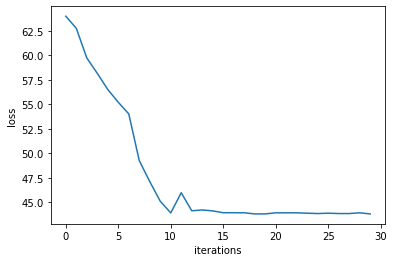

In [22]:
fit(model, 30, train_loader, valid_loader, optimizer)

In [24]:
torch.save(model, './c3d2.pth')